In [2]:
#reload source files automatically
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import accuracy_score as acc
import numpy as np
from lime import explanation
from lime import lime_base
from lime_timeseries import LimeTimeSeriesExplanation

In [71]:
coffee_train = pd.read_csv('coffee_train.csv', sep=',', header=None).astype(float)
coffee_train_y = coffee_train.loc[:, 0]
coffee_train_x = coffee_train.loc[:, 1:]
coffee_test = pd.read_csv('coffee_test.csv', sep=',', header=None).astype(float)
coffee_test_y = coffee_test.loc[:, 0]
coffee_test_x = coffee_test.loc[:, 1:]

## Coffee Dataset

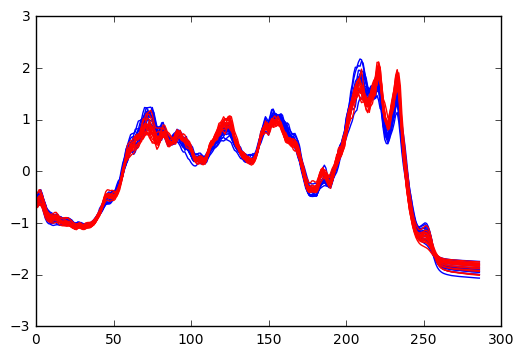

In [67]:
for idx in range(0, len(coffee_train)):
    if coffee_train_y[idx] == 0:
        plt.plot(coffee_train_x.loc[idx, :], 'b')
    else:
        plt.plot(coffee_train_x.loc[idx, :], 'r')
plt.show()

### Compute Accuracy

In [6]:
knn = KNN()
knn.fit(coffee_train_x, coffee_train_y)
acc(coffee_test_y, knn.predict(coffee_test_x))

0.9642857142857143

In [68]:
print(coffee_train_x.loc[22, :])

1     -0.62617
2     -0.55687
3     -0.54580
4     -0.58558
5     -0.67391
6     -0.76623
7     -0.82892
8     -0.86945
9     -0.88106
10    -0.87628
11    -0.85911
12    -0.84051
13    -0.85035
14    -0.88229
15    -0.92427
16    -0.96566
17    -1.00250
18    -1.02270
19    -1.01880
20    -1.02950
21    -1.04690
22    -1.05520
23    -1.07940
24    -1.09960
25    -1.10000
26    -1.09320
27    -1.06720
28    -1.02860
29    -1.02680
30    -1.04140
        ...   
257   -1.64850
258   -1.67630
259   -1.69740
260   -1.71210
261   -1.72350
262   -1.73170
263   -1.73830
264   -1.74400
265   -1.74840
266   -1.75140
267   -1.75510
268   -1.75890
269   -1.76140
270   -1.76300
271   -1.76520
272   -1.76690
273   -1.76890
274   -1.77180
275   -1.77530
276   -1.77720
277   -1.77920
278   -1.78240
279   -1.78530
280   -1.78800
281   -1.79060
282   -1.79350
283   -1.79600
284   -1.79780
285   -1.79900
286   -1.80020
Name: 22, dtype: float64


C:\Users\Emanuel\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


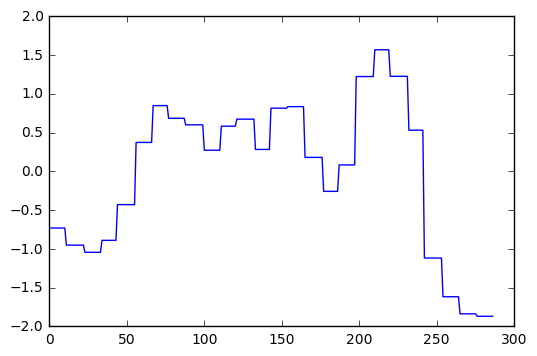

In [72]:
idx = 22
explainer = LimeTimeSeriesExplanation(class_names=['0', '1'])
data, labels, series = explainer.explain_instance(coffee_train_x.loc[idx, :], knn.predict_proba, num_features=len(coffee_train_x.loc[0, :]), training_set=coffee_train_x)
#print(explainer.__data_labels_distances(coffee_test_x[idx], knn.predict_proba, 10, 20, coffee_train_x))
plt.plot(series[0])
plt.show()